Background:
----------
4875 tweets were randomly generated in mongodb (excluding retweets). Tweets were labeled as Relevant (R or 1) or Non-Relevant (N or 0) by two researchers (Stefan and I). A tweet was considered relevant if it contained words that were suggestive of clinical trialrecruitment and had wording related to illness or disease, gender, or age (e.g. “Are you a teen with Celiac’s disease? If so, you may eligible to join our #clinicaltrials”). The final result of this was 163 relevant tweets (1) and 4711 junk tweets (0). Their were 3.26% relevant tweets that Stefan and I agree on. 95.4% of total tweets Stefan and I agree on. The training dataset is called "merged_clean_tweets.xlsx."


Goal:
-----

1) Use supervised machine learning to obtain relevant tweets

2) Obtain a final list of the Tweet IDs for relevant tweets


Summary:
------

I tried various different classifiers (not all shown here), including random forests and SVM. Ultimately, I used KNN because it gave me the best precision score to correctly select relevant tweets.

In [1]:
# Import modules

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import numpy

from sklearn import cross_validation
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import KFold
from sklearn.svm import SVC

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read excel spreadsheet containing labeled training dataset
df = pd.read_excel('merged_clean_tweets.xlsx')
df.head(5)

,Label,Tweet_ID,Tweet_Text
0,N,933684102854856704,Happy Thanksgiving! Be blessed! 🦃🦃#abundance ...
1,N,910474153303564288,* Roivant Sciences Launches Datavant to Improv...
2,N,935005634407301120,https://t.co/l4MvIt5gtF Optimal response and c...
3,N,923163318499598336,Funding Lowerpriority Clinical Trials - Shared...
4,N,931110626608508928,Machine learning could improve our ability to ...


In [3]:
# look at number of rows and columns
df.shape

(4874, 3)

In [4]:
# get all R = relevant tweet
df_Relevant = df.loc[df['Label'] == 'R']
print(df_Relevant.shape)
df_Relevant.head(10)

(163, 3)


,Label,Tweet_ID,Tweet_Text
22,R,944629319539638272,Sign up for our next webinar to learn about tr...
72,R,932562232818520064,Is your breast cancer advanced or metastatic? ...
96,R,903695461705535488,New research looking at the #microbiome &amp; ...
130,R,937826557346893824,A study to test an investigational drug in pat...
241,R,942069320590548992,A study to test an investigational drug in pat...
248,R,900339156613771264,Be a Clinical #Research #Volunteer – Who Me? –...
279,R,907336320154062848,"Today, my #osteoarthritis won/t slow me down! ..."
286,R,938880521861582848,"The Baltimore Early Phase Clinical Unit, locat..."
325,R,927654480228872192,PAREXEL Paid Clinical Trial on Healthy Male Vo...
333,R,919665946939211776,#web Join Paid Clinical Trials &amp; Earn U...


In [5]:
# get all N values
N = df.loc[df['Label'] == 'N']
print(N.shape)
N.head(10)

(4711, 3)


,Label,Tweet_ID,Tweet_Text
0,N,933684102854856704,Happy Thanksgiving! Be blessed! 🦃🦃#abundance ...
1,N,910474153303564288,* Roivant Sciences Launches Datavant to Improv...
2,N,935005634407301120,https://t.co/l4MvIt5gtF Optimal response and c...
3,N,923163318499598336,Funding Lowerpriority Clinical Trials - Shared...
4,N,931110626608508928,Machine learning could improve our ability to ...
5,N,938868917644288000,I read a proposal which appeared to suggest th...
6,N,933058865356333056,"For Zika #clinicaltrials to succeed, it’s impo..."
7,N,935206947359461376,Cancer drug starts clinical trials in human br...
8,N,910334403741708288,"and after years of testing, hundreds of clinic..."
9,N,903317088340590592,Which city in #China had the most #clinicaltri...


In [6]:
# randomly select 2000 N from junk tweet
df_junk = N.sample(n=2000)
print(df_junk.shape)
df_junk.head(10)

(2000, 3)


,Label,Tweet_ID,Tweet_Text
1655,N,899289931473973248,Clinical Trials Auditor at University of Oxfor...
1893,N,898382963573800960,National Cancer Inst: NCI/s Community Oncology...
1126,N,906190504869732352,NIH controversy: Should human mind and brain r...
419,N,919266931328270336,@kdrarvind it is not the courts job to experim...
1232,N,895993468979482624,#clinicaltrial Internet-delivered CBT vs Inter...
2036,N,939966144181620736,Some people say clinical trials would have to ...
2503,N,928291166172405760,The future of #ClinicalTrials\n\nRead Article:...
591,N,903311972975820800,Japanese neuroscientists plan first-ever clini...
4174,N,895340046152220672,#Travelnurses in #isolated Nevada. #Clinicaltr...
3450,N,910505109699915776,Why #digitalhealth is beneficial to clinical t...


In [7]:
# combine relevant (df1) and junk tweets (df2) into new df
new_df = df_Relevant.append(df_junk, ignore_index=True)
new_df.head(10)

,Label,Tweet_ID,Tweet_Text
0,R,944629319539638272,Sign up for our next webinar to learn about tr...
1,R,932562232818520064,Is your breast cancer advanced or metastatic? ...
2,R,903695461705535488,New research looking at the #microbiome &amp; ...
3,R,937826557346893824,A study to test an investigational drug in pat...
4,R,942069320590548992,A study to test an investigational drug in pat...
5,R,900339156613771264,Be a Clinical #Research #Volunteer – Who Me? –...
6,R,907336320154062848,"Today, my #osteoarthritis won/t slow me down! ..."
7,R,938880521861582848,"The Baltimore Early Phase Clinical Unit, locat..."
8,R,927654480228872192,PAREXEL Paid Clinical Trial on Healthy Male Vo...
9,R,919665946939211776,#web Join Paid Clinical Trials &amp; Earn U...


In [8]:
# shuffle relevant and junk 
df_2000=new_df.sample(frac=1)
df_2000.head(10)

,Label,Tweet_ID,Tweet_Text
2151,N,940904678153490432,Staying active with neuropathy | MSU Extension...
1794,N,899783982954364928,#copd news: Chronic Obstructive Pulmonary Dise...
1078,N,944643841461809152,@healthcare178 I personally have not participa...
1572,N,922387754755002368,Looking for a resource for advising individual...
900,N,915894873848348672,Insightful videos about #cancer #ClinicalTrial...
590,N,925381340781932544,New approaches to #clinicaltrials can help res...
902,N,905501756402130944,#prnewswire Dupuytren Contracture Global Clin...
1680,N,930421915692527616,$ADAP Outlines Study Designs for Two T-Cell Cl...
1022,N,907937050665644032,Richard Strobridge discusses the IoE and how i...
1058,N,936644573408849920,World AIDS Day: The Role of Clinical Trials......


In [9]:
# look at shape of dataframe
df_2000.shape

(2163, 3)

In [10]:
#X = tweets ['Because of your donation, research is taking place in vital areas of cardiac care – including atrial fibrillation,… https://t.co/5paF7tnPiL', 'Volunteers With High Uric Acid Needed - Glendale CA: The California Clinical Trials Medical… https://t.co/eEtabZB6KY', 'Truly an epidemic and companies like @purduepharma hv a strong role in it. Be #responsible in clinical trials not f… https://t.co/80LV7683xI', 'We/ll be in Boston this week at #OCTNE at Booth 46 to discuss the latest technology in #clinicaltrials &amp; healthcare… https://t.co/BRmIDaudss', '#Healthyvolunteers needed for #migraine study analyzing speech patterns. #MayoClinicAZ https://t.co/60gFmbsUV5 https://t.co/QTxhCRMr7w']
#y = labels ["n", "r", "n", "n", "r"]

# make X and y into list
X_list= df_2000['Tweet_Text'].tolist()
y_list = df_2000['Label'].tolist()

print(len(X_list))
print(y_list[:5])

2163
['N', 'N', 'N', 'N', 'N']


In [11]:
# verify X and y are correct
print(X_list)
print(len(y_list))

['Staying active with neuropathy | MSU Extension #clinicaltrials https://t.co/dFwYZQ5N2P', '#copd news: Chronic Obstructive Pulmonary Disease COPD Global Clinical Trials Review H1 2017 Report Updated 300... https://t.co/x6lOSe730Q', '@healthcare178 I personally have not participated in any clinical trials, yet. There is so much promising, breakthr… https://t.co/vfx1yCji0I', 'Looking for a resource for advising individuals looking to get involved with stem cell clinical trials? Check out: https://t.co/UaeQn8nG6y', 'Insightful videos about #cancer #ClinicalTrials from doctors &amp; patients. Watch now. @CancerSupportCM https://t.co/WbgcVjUvJZ', 'New approaches to #clinicaltrials can help researchers understand how a therapy impacts ppl w/ #hemophilia #NHF2017… https://t.co/lpbpaKW2tY', '#prnewswire\xa0 Dupuytren Contracture Global Clinical Trials Review, H2, 2017 https://t.co/cQgmd0H9E9', '$ADAP Outlines Study Designs for Two T-Cell Clinical Trials - MAGE-A4 and NY-ESO SPEAR https://t.co

In [12]:
# convert y into an array
X = X_list
y = np.asarray(y_list)
print(len(X)) 
print(len(y))
print(type(X))
print(type(y))

2163
2163
<class 'list'>
<class 'numpy.ndarray'>


In [13]:
# convert X from string to float using tf-idf
tfidf = TfidfVectorizer()
X_vec = tfidf.fit_transform(X)  

In [14]:
# convert X to array
X = X_vec.toarray()
X

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [15]:
# quick peek into X and y
print(X[:5])
print(y[:5])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
['N' 'N' 'N' 'N' 'N']


In [16]:
# verify X and y shape
print(X.shape)
print(y.shape)

(2163, 8855)
(2163,)


# 20 fold validation

In [17]:
# 20 fold validation
skf = StratifiedKFold(n_splits=20) 

In [18]:
#Returns the number of splitting iterations in the cross-validator
skf.get_n_splits(X, y)

20

In [19]:
# skf.split generates indices to split data into training and test set.
for train_index, test_index in skf.split(X, y): 
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [  56   68   94 ..., 2160 2161 2162] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  57  58  59  60  61  62  63  64  65  66  67  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  96  97  98 100 101 102 103 104 105 106 107 108 109 110 111 112
 113]
TRAIN: [   0    1    2 ..., 2160 2161 2162] TEST: [ 56  68  94  95  99 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 157 158 159 160 161 162 163
 164 165 166 168 170 171 172 173 174 175 176 177 178 179 180 182 183 184
 185 186 187 188 189 190 192 193 194 195 196 197 198 199 200 201 202 203
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223]
TRAIN: [   0

TRAIN: [   0    1    2 ..., 2160 2161 2162] TEST: [1660 1666 1682 1687 1691 1736 1737 1738 1739 1740 1741 1742 1743 1744 1745
 1746 1747 1748 1749 1750 1751 1752 1753 1754 1755 1756 1757 1758 1759 1760
 1761 1762 1763 1764 1765 1766 1767 1768 1769 1770 1772 1773 1774 1775 1777
 1778 1779 1780 1781 1782 1783 1784 1785 1787 1788 1790 1791 1792 1793 1794
 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805 1806 1807 1808 1809
 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819 1820 1821 1822 1823 1824
 1825 1826 1827 1828 1829 1830 1831 1832 1833 1834 1835 1836 1837 1838 1839
 1840 1842 1843]
TRAIN: [   0    1    2 ..., 2160 2161 2162] TEST: [1771 1776 1786 1789 1841 1844 1845 1846 1847 1848 1849 1850 1851 1852 1853
 1854 1855 1856 1857 1859 1860 1861 1862 1863 1864 1865 1866 1867 1868 1869
 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884
 1885 1886 1887 1888 1889 1890 1891 1893 1894 1895 1896 1897 1899 1900 1901
 1902 1903 1904 1905 1906 1907 1908 1909 1910 1

# KNN

I originally used an svm classifier with a linear kernel. But after some trial and error, I used KNN instead because it gave me a better precision score. My goal was to correctly label R tweets and minimize false positives (N incorrectly labeled as R). Because of this, a precision score is ideal, since it measures how well my model labels R tweets.  

In [20]:
# instantiate KNN classifier
clf = KNeighborsClassifier(n_neighbors=10)

In [21]:
#create an empty list to store scores
accuracy_scores = [] 
precision_scores = []
recall_scores = []

In [22]:
#loop through and split data into test and train
for train_index, test_index in skf.split(X, y): 
    
    #create train and test
    #X
    X_train = X[train_index]
    X_test =  X[test_index]
    #y
    y_train = y[train_index]
    y_test =  y[test_index]
    
    #fit the svm model 
    clf = KNeighborsClassifier(n_neighbors=10)
    y_pred = clf.fit(X_train, y_train).predict(X_test)    
    
    #get scores
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average='macro')) 
    recall_scores.append(recall_score(y_test, y_pred, average='macro'))
    

In [23]:
#high accuracy = The fraction of predictions our model got right
print(accuracy_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(accuracy_scores), np.std(accuracy_scores) * 2))    

#high precision = Not many relevant tweets predicited as junk tweets
print(precision_scores)
print("Precision: %0.2f (+/- %0.2f)" % (np.mean(precision_scores), np.std(precision_scores) * 2))

#high recall = Predicted most junk tweets correctly
print(recall_scores)
print("Recall: %0.2f (+/- %0.2f)" % (np.mean(recall_scores), np.std(recall_scores) * 2))

[0.96330275229357798, 0.98165137614678899, 0.96330275229357798, 0.97222222222222221, 0.98148148148148151, 0.95370370370370372, 0.97222222222222221, 0.96296296296296291, 0.95370370370370372, 0.98148148148148151, 0.96296296296296291, 0.94444444444444442, 0.97222222222222221, 0.97222222222222221, 0.97222222222222221, 0.97222222222222221, 0.9907407407407407, 0.9907407407407407, 0.9907407407407407, 0.97222222222222221]
Accuracy: 0.97 (+/- 0.02)
[0.91386554621848737, 0.99019607843137258, 0.91386554621848737, 0.9854368932038835, 0.99019607843137258, 0.81302717900656041, 0.9854368932038835, 0.86499999999999999, 0.84229137199434234, 0.9325, 0.90196078431372551, 0.85096153846153844, 0.91867043847241869, 0.91867043847241869, 0.91867043847241869, 0.91867043847241869, 0.99504950495049505, 0.99504950495049505, 0.94444444444444442, 0.9854368932038835]
Precision: 0.93 (+/- 0.11)
[0.82833333333333337, 0.88888888888888884, 0.82833333333333337, 0.8125, 0.875, 0.91749999999999998, 0.8125, 0.86499999999999

# Plotting Precision and Recall

Since my data had imbalanced classes, I used the AUC for a precision-recall curve to evaluate my KNN classifier

In [24]:
#convert N = 0, R = 1 so I can use for loop below
#else it throws error: ValueError: Data is not binary and pos_label is not specified

# convert label to a numerical variable
df_2000['Label_Num'] = df_2000.Label.map({'N':0, 'R':1})

# check that the conversion worked
df_2000.head(10)

,Label,Tweet_ID,Tweet_Text,Label_Num
2151,N,940904678153490432,Staying active with neuropathy | MSU Extension...,0
1794,N,899783982954364928,#copd news: Chronic Obstructive Pulmonary Dise...,0
1078,N,944643841461809152,@healthcare178 I personally have not participa...,0
1572,N,922387754755002368,Looking for a resource for advising individual...,0
900,N,915894873848348672,Insightful videos about #cancer #ClinicalTrial...,0
590,N,925381340781932544,New approaches to #clinicaltrials can help res...,0
902,N,905501756402130944,#prnewswire Dupuytren Contracture Global Clin...,0
1680,N,930421915692527616,$ADAP Outlines Study Designs for Two T-Cell Cl...,0
1022,N,907937050665644032,Richard Strobridge discusses the IoE and how i...,0
1058,N,936644573408849920,World AIDS Day: The Role of Clinical Trials......,0


In [25]:
# get Label_num
Label_num = df_2000.iloc[:, 3:4]
Label_num.head(30)

,Label_Num
2151,0
1794,0
1078,0
1572,0
900,0
590,0
902,0
1680,0
1022,0
1058,0


In [26]:
# make into matrix
Label_num_matrix = Label_num.as_matrix()
Label_num_matrix[0:30]
Label_num_matrix.shape

(2163, 1)

In [27]:
# flatten matrix
flat_matrix = Label_num_matrix.flatten()
flat_matrix

array([0, 0, 0, ..., 0, 1, 0])

In [28]:
# use this as my y
flat_matrix.shape #these are N= 0, R = 1

(2163,)

In [29]:
# set up subplots
f, axes = plt.subplots(1, 2, figsize=(10, 5))

In [30]:
# use 20 fold cross validation
FOLDS = 20
k_fold = KFold(n_splits=FOLDS, shuffle=True, random_state=12345)

In [31]:
# use KNN 
predictor = KNeighborsClassifier(n_neighbors=10)

In [32]:
#make empty list
y_real = []
y_proba = []

y = flat_matrix

#loop through folds
for i, (train_index, test_index) in enumerate(k_fold.split(X)): 
    
    #X
    X_train = X[train_index]
    X_test =  X[test_index]
    #y
    y_train = y[train_index]
    y_test =  y[test_index] 
    
    
    #fit the KNN model on train
    predictor = KNeighborsClassifier(n_neighbors=10)
    predictor.fit(X_train, y_train)
    
    #Predict probabilities on test
    pred_proba = predictor.predict_proba(X_test) 
    
    #make precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:,1]) 
    
    #label in legend
    #AUC = area under curve
    lab = 'Fold %d AUC=%.4f' % (i+1, auc(recall, precision)) 
    
    #create step plot
    axes[1].step(recall, precision, label=lab)
    
    #append to empty list
    y_real.append(y_test)
    y_proba.append(pred_proba[:,1])

In [33]:
# Join a sequence of arrays 
y_real = numpy.concatenate(y_real) 

In [34]:
# Join a sequence of arrays 
y_proba = numpy.concatenate(y_proba)

In [35]:
#pass true labels (y_real) and predicted probabilities to precision recall
precision, recall, _ = precision_recall_curve(y_real, y_proba) 

# plot precision-recall curve

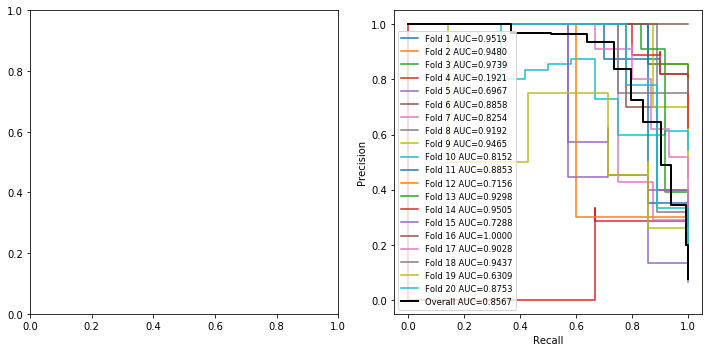

In [36]:
#label in legend
lab = 'Overall AUC=%.4f' % (auc(recall, precision))

#create plot
axes[1].step(recall, precision, label=lab, lw=2, color='black')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left', fontsize='small')

#show plot
f.tight_layout()
f.savefig('precision_recall_plot.png')
plt.show()

simple terms:
high precision means that an algorithm returned substantially more relevant results than irrelevant ones
high recall means that an algorithm returned most of the relevant results

precision (positive predictive value) = how many selected values are relevant tweets? (tp / tp + fp)
"how useful the search results are"
tp/ number of predicted positive

recall (sensitivity) = how many relevant items have been selected (tp / tp + fn)
how complete the results are
max recall = no false negatives
tp/number of actual positive

# Predict on original

In [37]:
# import "ORIGINAL DATASET" = Clean_Tweets_100 df
df_cleantweets = pd.read_excel('Clean_Tweets_271000.xlsx') 
print(df_cleantweets.head(10))
print(df_cleantweets.shape)

             Tweet_ID                                         Tweet_Text
0  896015560315744261  RT @PCTGrandRounds: 1pm ET today @PCTGrandRoun...
1  896015466472382470  Achieve Life Sciences cleared tо start U.S. cl...
2  896015422532857858  Also a big deal in #clinicaltrials @AGMednet h...
3  896015105086894080  RT @NINDSfunding: @NINDSfunding changes key da...
4  896015008164872192  This is what is currently happening to my 29 y...
5  896014920315281410  RT @theNCI: Clinical trials, which are researc...
6  896014864329707524  RT @statnews: .@US_FDA wants to use computer m...
7  896014737548476417  RT @ResearchAmerica: A6: 75% of Americans agre...
8  896014659194687489  @NINDSfunding changes key dates for #NeuroNEXT...
9  896014546883813376  @OriginalCoolski @profmusgrave @KarenJBateson ...
(271144, 2)


In [38]:
# make list
text = df_cleantweets['Tweet_Text'].tolist()
print(text[:5])

['RT @PCTGrandRounds: 1pm ET today @PCTGrandRounds: Embedding Clinical Trials Into Care Delivery: The Vanderbilt Experience https://t.co/0rCh…', 'Achieve Life Sciences cleared tо start U.S. clinical trials оn smоking cessatiоn med… https://t.co/j6cb63ES8C https://t.co/IbiofYSND1', 'Also a big deal in #clinicaltrials @AGMednet https://t.co/6nZStavbbg', 'RT @NINDSfunding: @NINDSfunding changes key dates for #NeuroNEXT funding opp. Learn more: https://t.co/mNLWdwjwO4 #clinicaltrials https://t…', 'This is what is currently happening to my 29 year old friend Justin :( #CancerCHE @SU2C #clinicaltrials… https://t.co/mDQtW4j3ut']


In [39]:
# vectorize
text_vec = tfidf.transform(text).toarray() 
text_vec

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [40]:
# predict labels on new data
clf = KNeighborsClassifier(n_neighbors=10)

In [41]:
# trained over all of labeled data 
clf.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [42]:
# predict labels
label_pred = clf.predict(text_vec)

In [43]:
# show 100 predicted labels
label_pred[0:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0])

In [44]:
# check label length
len(label_pred)

271144

# Add labels to column

In [45]:
# add y_hats column
df_cleantweets['Label_Predictions'] = label_pred
df_cleantweets

,Tweet_ID,Tweet_Text,Label_Predictions
0,896015560315744261,RT @PCTGrandRounds: 1pm ET today @PCTGrandRoun...,0
1,896015466472382470,Achieve Life Sciences cleared tо start U.S. cl...,0
2,896015422532857858,Also a big deal in #clinicaltrials @AGMednet h...,0
3,896015105086894080,RT @NINDSfunding: @NINDSfunding changes key da...,0
4,896015008164872192,This is what is currently happening to my 29 y...,0
5,896014920315281410,"RT @theNCI: Clinical trials, which are researc...",0
6,896014864329707524,RT @statnews: .@US_FDA wants to use computer m...,0
7,896014737548476417,RT @ResearchAmerica: A6: 75% of Americans agre...,0
8,896014659194687489,@NINDSfunding changes key dates for #NeuroNEXT...,0
9,896014546883813376,@OriginalCoolski @profmusgrave @KarenJBateson ...,0


In [46]:
# groupby 
df_cleantweets.groupby('Label_Predictions').count()

,Tweet_ID,Tweet_Text
Label_Predictions,,
0,263570,263570
1,7574,7574


# Keep relevant ('R') tweets, clean the data, and make a new dataframe

In [48]:
# keep only R tweets 
R_df = df_cleantweets.loc[df_cleantweets['Label_Predictions'] == 1]
R_df

,Tweet_ID,Tweet_Text,Label_Predictions
92,896000451111464961,RT @FabryAustralia: Have you been diagnosed wi...,1
129,895993682561826817,If you are a healthy adult with plaque psorias...,1
165,895993382278844418,Have you or loved one been diagnosed with a Va...,1
190,895988695290880001,RT @theNCI: Do you need help finding a cancer ...,1
210,895983815977558017,RT @sloan_kettering: Not sure if a #clinicaltr...,1
212,895982962663198725,RT @sloan_kettering: Not sure if a #clinicaltr...,1
219,895981387882258433,RT @sloan_kettering: Not sure if a #clinicaltr...,1
470,895955270731542529,RT @theNCI: If you need help finding a cancer ...,1
532,895945176279068673,RT @PanCAN: Search for a #pancreaticcancer #cl...,1
546,895943153445982209,RT @Trials4Us: #clinicaltrial for healthy Cauc...,1


In [49]:
# remove RT @ symbols
noRT_df = R_df[R_df['Tweet_Text'].str.contains('RT @') == False]
noRT_df 

,Tweet_ID,Tweet_Text,Label_Predictions
129,895993682561826817,If you are a healthy adult with plaque psorias...,1
165,895993382278844418,Have you or loved one been diagnosed with a Va...,1
877,895842649390931968,If you are a patient with metastatic cancer in...,1
1011,895837885886287872,"Peter Leary, MD on patient education in #Clini...",1
1245,895829312120795136,Healthy volunteers also imp in clinical trials...,1
1307,895827143925653504,If you are interested in searching for #lungca...,1
1830,895806869503168514,If you need help finding a cancer #clinicaltri...,1
1926,895778656714358784,@steveubl Patients in clinical trials . GOD BL...,1
1954,895766980011208704,We are currently seeking adolescent and young ...,1
2140,895724182431858689,Do you have #diabetes? Learn more about 2 new ...,1


In [50]:
# remove RT symbols
noRT_df = R_df[R_df['Tweet_Text'].str.contains('RT') == False]
noRT_df 

,Tweet_ID,Tweet_Text,Label_Predictions
129,895993682561826817,If you are a healthy adult with plaque psorias...,1
165,895993382278844418,Have you or loved one been diagnosed with a Va...,1
877,895842649390931968,If you are a patient with metastatic cancer in...,1
1011,895837885886287872,"Peter Leary, MD on patient education in #Clini...",1
1245,895829312120795136,Healthy volunteers also imp in clinical trials...,1
1307,895827143925653504,If you are interested in searching for #lungca...,1
1830,895806869503168514,If you need help finding a cancer #clinicaltri...,1
1926,895778656714358784,@steveubl Patients in clinical trials . GOD BL...,1
1954,895766980011208704,We are currently seeking adolescent and young ...,1
2140,895724182431858689,Do you have #diabetes? Learn more about 2 new ...,1


In [51]:
# delete duplicates
noDup_df= noRT_df.drop_duplicates(subset=['Tweet_Text'], keep="first") 
noDup_df

,Tweet_ID,Tweet_Text,Label_Predictions
129,895993682561826817,If you are a healthy adult with plaque psorias...,1
165,895993382278844418,Have you or loved one been diagnosed with a Va...,1
877,895842649390931968,If you are a patient with metastatic cancer in...,1
1011,895837885886287872,"Peter Leary, MD on patient education in #Clini...",1
1245,895829312120795136,Healthy volunteers also imp in clinical trials...,1
1307,895827143925653504,If you are interested in searching for #lungca...,1
1830,895806869503168514,If you need help finding a cancer #clinicaltri...,1
1926,895778656714358784,@steveubl Patients in clinical trials . GOD BL...,1
1954,895766980011208704,We are currently seeking adolescent and young ...,1
2140,895724182431858689,Do you have #diabetes? Learn more about 2 new ...,1


String split (to delete very similar duplicates)

example:
erase these:

6658	894879617760219000	Do you or a loved one have #stomachcancer? @NCI_TGIB has #clinicaltrials for you @NCIResearchCtr . @NoStomach4Cancr… https://t.co/SDRctq5B2u

6659	894879614367085000	Do you or a loved one have #stomachcancer? @NCI_TGIB has #clinicaltrials for you @NCIResearchCtr . @NoStomach4Cancr… https://t.co/oAbow4DzKB

In [52]:
#make list of text col
dfList = noDup_df['Tweet_Text'].tolist()
print(len(dfList))
print(dfList[0:5])

4833
['If you are a healthy adult with plaque psoriasis, you may qualify for a research study. \nsee: https://t.co/lu0q0snr3q\n#rash\n #clinicaltrial', 'Have you or loved one been diagnosed with a Vascular #Disease? Find treatment through #clinicaltrials, https://t.co/6B3QgmWy7o', 'If you are a patient with metastatic cancer interested in clinical trials, please read our FAQs: https://t.co/4RCqmJMvNk #FirstInHuman', 'Peter Leary, MD on patient education in #ClinicalTrials (Part 3) phaware® podcast Ep 84\xa0 https://t.co/6WE1sGBDqd', 'Healthy volunteers also imp in clinical trials as their health info used for comparison &amp; more. #FirstInHuman https://t.co/CwU9IfdjO5']


In [53]:
# split https
split = [i.split('https:', 1)[0] for i in dfList]
split[49:52]

['How To Try An Experimental Drug When You Don/t Qualify For A #ClinicalTrial ',
 '#clinicaltrial Feasibility Study of Induction and Maintenance Avelumab Plus R-CHOP in Patients With Diffuse DLBCL:… ',
 'How to try an experimental drug when you don/t qualify for a clinical trial ']

In [54]:
# put list back in df
noDup_df['Split_Text'] = split
noDup_df

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Tweet_ID,Tweet_Text,Label_Predictions,Split_Text
129,895993682561826817,If you are a healthy adult with plaque psorias...,1,If you are a healthy adult with plaque psorias...
165,895993382278844418,Have you or loved one been diagnosed with a Va...,1,Have you or loved one been diagnosed with a Va...
877,895842649390931968,If you are a patient with metastatic cancer in...,1,If you are a patient with metastatic cancer in...
1011,895837885886287872,"Peter Leary, MD on patient education in #Clini...",1,"Peter Leary, MD on patient education in #Clini..."
1245,895829312120795136,Healthy volunteers also imp in clinical trials...,1,Healthy volunteers also imp in clinical trials...
1307,895827143925653504,If you are interested in searching for #lungca...,1,If you are interested in searching for #lungca...
1830,895806869503168514,If you need help finding a cancer #clinicaltri...,1,If you need help finding a cancer #clinicaltri...
1926,895778656714358784,@steveubl Patients in clinical trials . GOD BL...,1,@steveubl Patients in clinical trials . GOD BL...
1954,895766980011208704,We are currently seeking adolescent and young ...,1,We are currently seeking adolescent and young ...
2140,895724182431858689,Do you have #diabetes? Learn more about 2 new ...,1,Do you have #diabetes? Learn more about 2 new ...


In [55]:
# delete dups
noDup_df1 = noDup_df.drop_duplicates(subset=['Split_Text'], keep="first")
noDup_df1

,Tweet_ID,Tweet_Text,Label_Predictions,Split_Text
129,895993682561826817,If you are a healthy adult with plaque psorias...,1,If you are a healthy adult with plaque psorias...
165,895993382278844418,Have you or loved one been diagnosed with a Va...,1,Have you or loved one been diagnosed with a Va...
877,895842649390931968,If you are a patient with metastatic cancer in...,1,If you are a patient with metastatic cancer in...
1011,895837885886287872,"Peter Leary, MD on patient education in #Clini...",1,"Peter Leary, MD on patient education in #Clini..."
1245,895829312120795136,Healthy volunteers also imp in clinical trials...,1,Healthy volunteers also imp in clinical trials...
1307,895827143925653504,If you are interested in searching for #lungca...,1,If you are interested in searching for #lungca...
1830,895806869503168514,If you need help finding a cancer #clinicaltri...,1,If you need help finding a cancer #clinicaltri...
1926,895778656714358784,@steveubl Patients in clinical trials . GOD BL...,1,@steveubl Patients in clinical trials . GOD BL...
1954,895766980011208704,We are currently seeking adolescent and young ...,1,We are currently seeking adolescent and young ...
2140,895724182431858689,Do you have #diabetes? Learn more about 2 new ...,1,Do you have #diabetes? Learn more about 2 new ...


In [56]:
# eliminate Split_Text column
noDup_df2 = noDup_df1.iloc[:, 0:3]
noDup_df2

,Tweet_ID,Tweet_Text,Label_Predictions
129,895993682561826817,If you are a healthy adult with plaque psorias...,1
165,895993382278844418,Have you or loved one been diagnosed with a Va...,1
877,895842649390931968,If you are a patient with metastatic cancer in...,1
1011,895837885886287872,"Peter Leary, MD on patient education in #Clini...",1
1245,895829312120795136,Healthy volunteers also imp in clinical trials...,1
1307,895827143925653504,If you are interested in searching for #lungca...,1
1830,895806869503168514,If you need help finding a cancer #clinicaltri...,1
1926,895778656714358784,@steveubl Patients in clinical trials . GOD BL...,1
1954,895766980011208704,We are currently seeking adolescent and young ...,1
2140,895724182431858689,Do you have #diabetes? Learn more about 2 new ...,1


In [57]:
# (excel makes 896013350764773376 into 8.96013E+17; strings preseves 896013350764773376)

# convert ID into strings
ID_List = noDup_df2['Tweet_ID'].tolist()
ID_List_str = list(map(str, ID_List))
ID_List_str

['895993682561826817',
 '895993382278844418',
 '895842649390931968',
 '895837885886287872',
 '895829312120795136',
 '895827143925653504',
 '895806869503168514',
 '895778656714358784',
 '895766980011208704',
 '895724182431858689',
 '895718606717177857',
 '895714027636228096',
 '895701018402365440',
 '895697256149635072',
 '895679737842077696',
 '895673625730220033',
 '895669573579673600',
 '895665604962566146',
 '895657193214582784',
 '895625921524150272',
 '895624652776771584',
 '895624648926351360',
 '895624616827379713',
 '895616043967819778',
 '895585847394930689',
 '895571588871008257',
 '895554295692632064',
 '895480775100874752',
 '895379908930785281',
 '895378510478495745',
 '895367080702246914',
 '895359265594068997',
 '895342563300921344',
 '895342293158428672',
 '895342189554925572',
 '895339573051498496',
 '895339214128254976',
 '895338822711468033',
 '895337938690596864',
 '895337313818914816',
 '895337119610060800',
 '895336370574475265',
 '895335411475558400',
 '895334311

In [58]:
# verify they are strings
type(ID_List_str[0])

str

In [59]:
#put list back in df
noDup_df2['Tweet_ID_str'] = ID_List_str
noDup_df2

,Tweet_ID,Tweet_Text,Label_Predictions,Tweet_ID_str
129,895993682561826817,If you are a healthy adult with plaque psorias...,1,895993682561826817
165,895993382278844418,Have you or loved one been diagnosed with a Va...,1,895993382278844418
877,895842649390931968,If you are a patient with metastatic cancer in...,1,895842649390931968
1011,895837885886287872,"Peter Leary, MD on patient education in #Clini...",1,895837885886287872
1245,895829312120795136,Healthy volunteers also imp in clinical trials...,1,895829312120795136
1307,895827143925653504,If you are interested in searching for #lungca...,1,895827143925653504
1830,895806869503168514,If you need help finding a cancer #clinicaltri...,1,895806869503168514
1926,895778656714358784,@steveubl Patients in clinical trials . GOD BL...,1,895778656714358784
1954,895766980011208704,We are currently seeking adolescent and young ...,1,895766980011208704
2140,895724182431858689,Do you have #diabetes? Learn more about 2 new ...,1,895724182431858689


In [60]:
#export in excel file
import pandas as pd
import xlsxwriter

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Relevant_Tweets_1652.xlsx', engine='xlsxwriter') #SAVED ON DROPBOX AS Relevant_Tweets_1652_UNCLEANED

# Convert the dataframe to an XlsxWriter Excel object.
noDup_df2.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [ ]:
# Keep IDs
# get only IDs and make list 
ID_List = df_1562['Tweet_ID_str'].tolist()
ID_List